In [1]:
import os
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from tkinter import filedialog as fd

In [2]:
class MZI_exp:
    def __init__(self, exp_name = "", wvl=[], vol=[], fsr=0, ext=[], minmax_short=[]):
        self.exp_name = exp_name
        self.wvl = wvl
        self.vol = vol
        self.fsr = fsr
        self.ext = ext
        self.minmax_short = minmax_short

class MZI:
    def __init__(self, col, row, num_experiments, leng = 0, qual = True): # see if num_experiments can be moved out later
        self.col = col
        self.row = row
        self.leng = leng
        self.exp = [None] * num_experiments
        self.qual = qual

    def printDetails(self):
            print(f"Device: ({self.col},{self.row}), PCM length: {self.leng} um")

In [3]:
# CREATE AN ARRAY OF BLANK MZIs MATCHING CHIP CONFIGURATION ########################################################## WORKING
def makeMZIarray(cols, rows, num_experiments):
    MZI_arr = []
    for j in range(cols): # 3
        row = []
        for i in range(rows):
            mzi = MZI(j+1,i+1, num_experiments)
            row.append(mzi)
        MZI_arr.append(row)

    for j in range(cols): # saveing the PCM length from my devices as a variable
        for i in range(rows):
            # print(f"column: {j} row: {i}")
            if j == 2:
                leng = 15
            else:
                leng = round(15 - i*1.1,1) 
                if (i) == 11:
                    leng = 0
            MZI_arr[j][i].leng = leng

    return(MZI_arr)

In [4]:
# #FOR DEBUGGING ###########################################################

# experiments = 2
# MZI_arr1 = makeMZIarray(3,12,experiments)

# # for j in range(cols):
# #     for i in range(rows):
# #         MZI_arr1[j][i].printDetails()

# col = 3
# row = 3

# exp_name = "test"
# wavelength_array = [1,1,1,1,1]
# voltage_array = [1,1,1,1,1]

# fsr = 12
# ext = [1,2,3]
# minmax_short = [1,2,3]

# exp_num = 0

# mziexp = MZI_exp(exp_name, wavelength_array, voltage_array, fsr, ext, minmax_short)

# # print(f"length of exp array should be 2: {len(MZI_arr[col-1][row-1].exp)}")

# # print(f'col-1: {col-1}, row-1: {row-1}, exp_num: {exp_num}')
# # MZI_arr1[col-1][row-1].printDetails()

# MZI_arr1[col-1][row-1].exp[exp_num] = mziexp

# print(MZI_arr1[col-1][row-1].exp[exp_num].fsr)
# print(MZI_arr1[col-1][row].exp[exp_num].fsr)

# print(MZI_arr1[col-1][row].exp[exp_num].fsr is MZI_arr1[col-1][row-1].exp[exp_num].fsr)

In [5]:
def addData(MZI_arr, folderpath, exp_num, exp_name):
    plt.rcParams['agg.path.chunksize'] = 10000 #prevents matplot crash if there are too many data points

    # #Popup Menu to select File
    # root = tk.Tk()
    # root.withdraw()  
    # folderpath = fd.askdirectory()
        
    #process all the files in the folder
    for filename in os.listdir(folderpath):
        if not filename.startswith('.') and os.path.isfile(os.path.join(folderpath, filename)):
            filepath = os.path.join(folderpath, filename)
            # print(filepath)
            wavelength = []
            voltage = []

            with open(filepath, 'r', encoding="utf-8", errors="ignore") as file:
                for line in file:
                    data = line.strip().split('\t')
                    wavelength.append(data[0])
                    if len(data) > 1:  # Ensure there are at least two elements
                        voltage.append(data[1])
                    else:
                        print(f"Skipping line due to insufficient data: ")
                        print(line)
            
            #Wavelength x-axis, Voltage y-axis
            wavelength_array = np.array(wavelength, dtype='float64')
            voltage_array = np.array(voltage, dtype='float64')
            
            #find the Maxima of the graph
            distance = 85000
            maxima, _ = signal.find_peaks(voltage_array, distance=distance)
            minima, _ = signal.find_peaks(-voltage_array, distance=distance)


            minmax = np.concatenate((maxima, minima))
            minmax.sort()


            np.diff(maxima) # check what this does
            fsr = 0
            avg_wave=0
            divisions = len(maxima)
            wave = wavelength_array[maxima]

            #Average FSR
            for i in range(1,len(wave)-1):
                avg_wave +=  wave[i] - wave[i-1]
            if(divisions>0):
                fsr = avg_wave/divisions



            minmax_short = []
            mid = len(minmax)//2 #good
            # # PRINT FOR DEBUGGING
            # print(f"mid: {mid}") #good
            # print(f"mid vol: {voltage_array[minmax[mid]]}") #good
            # print(f"mid wvl: {wavelength_array[minmax[mid]]}") #good

            ext = [] # extinction ratio
            num_points = 6 # only do even numbers for now
            if (voltage_array[minmax[mid]] < voltage_array[minmax[mid+1]]):
                minmax_short = minmax[mid-(num_points-1) : mid+num_points+2] 
            else:
                minmax_short = minmax[mid-num_points:mid+num_points+1]

            for i in range(num_points):
                ext.append(1 - (2*voltage_array[minmax_short[2*i+1]]) / (voltage_array[minmax_short[2*i]] + voltage_array[minmax_short[2*i+2]]))
                # #PRINT FOR DEBUGGING
                # print(f"(left {voltage_array[minmax_short[2*i]]} + right {voltage_array[minmax_short[2*i+2]]}) / (2* min {voltage_array[minmax_short[2*i+1]]})")
                # print(f"(left {wavelength_array[minmax_short[2*i]]} + right {wavelength_array[minmax_short[2*i+2]]}) / (2* min {wavelength_array[minmax_short[2*i+1]]})")

            # #PRINT FOR DEBUGGING
            # for i in range(len(ext)):
            #     print(ext[i])

            # SAVING DATA INTO THE MZI ARRAY #####################################################################

            col = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[0])
            row = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[1:])

            mziexp = MZI_exp(exp_name, wavelength_array, voltage_array, fsr, ext, minmax_short)

            print(f'col-1: {col-1}, row-1: {row-1}, exp_num: {exp_num}')
            MZI_arr[col-1][row-1].printDetails()

            MZI_arr[col-1][row-1].exp[exp_num] = mziexp

            print(MZI_arr[col-1][row-1].exp[exp_num].fsr)


In [6]:
def plotData(MZI_arr, col, row, exp_num, save = False):

    voltage_array = MZI_arr[col-1][row-1].exp[exp_num].vol
    wavelength_array = MZI_arr[col-1][row-1].exp[exp_num].wvl
    fsr = MZI_arr[col-1][row-1].exp[exp_num].fsr
    ext = MZI_arr[col-1][row-1].exp[exp_num].ext
    name = MZI_arr[col-1][row-1].exp[exp_num].exp_name

    min_voltage = np.min(voltage_array)
    max_voltage = np.max(voltage_array)

    #find the maxima and minima of the graph
    distance = 85000
    maxima, _ = signal.find_peaks(voltage_array, distance=distance)
    minima, _ = signal.find_peaks(-voltage_array, distance=distance)

    minmax = np.concatenate((maxima, minima))
    minmax.sort()

    #Graph Setup
    plt.figure(figsize=(12, 8))
    plt.title(f"Device ({col},{row}) - {name}")
    plt.xticks(np.arange(wavelength_array[0]-10, wavelength_array[-1]+10, 5.0))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Voltage (a.u.)")


    plt.plot(wavelength_array,voltage_array)
    plt.figtext(0.5,0.95, f"Average FSR: {fsr:.3f}, Average Extinction Ratio: {(sum(ext) / len(ext)):.3f}", horizontalalignment='center')

    plt.vlines(wavelength_array[maxima],min_voltage,max_voltage,linestyles="dashed",colors="lightblue")
    
    plt.plot(wavelength_array[maxima],voltage_array[maxima],"x")

    for points in maxima:
        plt.annotate(f"{wavelength_array[points]:.5f}", (wavelength_array[points],voltage_array[points]))

    # plt.plot(wavelength_array[minima],voltage_array[minima],"x")

    # plt.plot(wavelength_array[minmax],voltage_array[minmax],"x")


    minmax_short = []
    mid = len(minmax)//2 #good

    num_points = 6 # only do even numbers for now
    if (voltage_array[minmax[mid]] < voltage_array[minmax[mid+1]]):
        minmax_short = minmax[mid-(num_points-1) : mid+num_points+2] 
    else:
        minmax_short = minmax[mid-num_points:mid+num_points+1]
    
    j = 0
    for points in range(len(minmax_short)):
        if points%2 == 1:
            x = wavelength_array[minmax_short[points]]
            y = voltage_array[minmax_short[points]]
            plt.annotate(f"Ext: {ext[j]:.3f}", 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, -10),  # 10 points below the peak
                ha='center', 
                va='top',
                fontsize=8)
            j+=1

    # if (save == True):
    #     plt.savefig(f"{folderpath}/plots/{filename.split('.')[0]}.png", dpi=650, bbox_inches="tight")
    #     plt.close()

    plt.show()

In [7]:
def wvlShift(exp1,exp2,row,col,plot=True):
    diffsum = []

    max1 = []
    max2 = []
    min1 = []
    min2 = []
    for points in range(len(exp1.minmax_short)):
        if points%2 == 1: #peaks
            max1.append(exp1.wvl[exp1.minmax_short[points]])
            max2.append(exp2.wvl[exp2.minmax_short[points]])
        else: # troughs 
            min1.append(exp1.wvl[exp1.minmax_short[points]])
            min2.append(exp2.wvl[exp2.minmax_short[points]])



    for i in range(len(max1)):
        diffsum.append(max2[i]-max1[i])
    for i in range(len(min1)):
        diffsum.append(min2[i]-min1[i])
    
    diff = sum(diffsum)/len(diffsum)

    avgFSR = (exp1.fsr + exp2.fsr) / 2

    if diff < 0:
        diff += avgFSR
    elif diff > avgFSR:
        diff -= avgFSR
    
    diffRad = 2*diff/avgFSR

    ext1 = sum(exp1.ext)/len(exp1.ext)
    ext2 = sum(exp2.ext)/len(exp2.ext)

    print(f"Device ({col},{row}) - Wavelength Shift: {diff:.3f} nm ({diffRad:.3f}π rad)")
    print(f"{exp2.exp_name} - FSR: {exp2.fsr:.3f}, EXT: {ext2:.3f}")


    if(plot):
        #Graph Setup
        plt.figure(figsize=(12, 8))
        plt.title(f"Device ({col},{row}) - Wavelength Shift: {diff:.3f} nm ({diffRad:.3f}π rad)")
        plt.xticks(np.arange(exp1.wvl[0]-10, exp1.wvl[-1]+10, 5.0))
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Voltage (a.u.)")

        vol1 = exp1.vol/np.max(exp1.vol)
        vol2 = exp2.vol/np.max(exp2.vol)

        plt.plot(exp1.wvl,vol1,color="lightblue", label = exp1.exp_name)
        # plt.figtext(0.5,0.95, f"Average FSR: {exp1.fsr:.3f}, Average Extinction Ratio: {(sum(exp1.ext) / len(exp1.ext)):.3f}", horizontalalignment='center')

        plt.vlines(exp1.wvl[exp1.minmax_short],0,1,linestyles="dashed",colors="lightblue")
        plt.plot(exp1.wvl[exp1.minmax_short],vol1[exp1.minmax_short],"x")


        plt.plot(exp2.wvl,vol2,color="gold", label = exp2.exp_name)
        # plt.figtext(0.5,0.95, f"Average FSR: {exp2.fsr:.3f}, Average Extinction Ratio: {(sum(exp2.ext) / len(exp2.ext)):.3f}", horizontalalignment='center')

        plt.vlines(exp2.wvl[exp2.minmax_short],0,1,linestyles="dashed",colors="gold")
        plt.plot(exp1.wvl[exp2.minmax_short],vol2[exp2.minmax_short],"x")

        plt.legend()

        plt.show()
    else:
        return(diffRad)

    
        # plt.plot(exp1.wvl[maxima],voltage_array[maxima],"x")


    # return(diff)


In [8]:
num_experiments = 2
cols = 3
rows = 12
MZI_arr = makeMZIarray(cols,rows,num_experiments)

# for j in range(cols):
#     for i in range(rows):
#         MZI_arr[j][i].printDetails()


In [9]:
print(len(MZI_arr))
print(len(MZI_arr[0]))

3
12


In [10]:
datapath0 = '/Users/kamilakunes/BerkeleyLab/PCM_Project/Data/022124_PCM_short_MZI_Annealed'
exp_num = 0
addData(MZI_arr,datapath0,exp_num,'Before PCM Deposition')

datapath1 = '/Users/kamilakunes/BerkeleyLab/PCM_Project/Data/061225PCMiDep'
exp_num = 1
addData(MZI_arr,datapath1,exp_num,'After PCM Deposition (Crystalline)')

col-1: 2, row-1: 2, exp_num: 0
Device: (3,3), PCM length: 15 um
8.929909374999994
col-1: 0, row-1: 10, exp_num: 0
Device: (1,11), PCM length: 4.0 um
9.00242
col-1: 1, row-1: 3, exp_num: 0
Device: (2,4), PCM length: 11.7 um
8.992019999999997
col-1: 1, row-1: 7, exp_num: 0
Device: (2,8), PCM length: 7.3 um
9.016364999999993
col-1: 1, row-1: 5, exp_num: 0
Device: (2,6), PCM length: 9.5 um
8.999849374999997
col-1: 2, row-1: 0, exp_num: 0
Device: (3,1), PCM length: 15 um
8.944850000000002
col-1: 1, row-1: 6, exp_num: 0
Device: (2,7), PCM length: 8.4 um
8.591373529411772
col-1: 1, row-1: 2, exp_num: 0
Device: (2,3), PCM length: 12.8 um
8.885874999999999
col-1: 2, row-1: 5, exp_num: 0
Device: (3,6), PCM length: 15 um
8.846970000000002
col-1: 1, row-1: 1, exp_num: 0
Device: (2,2), PCM length: 13.9 um
8.955435624999993
col-1: 2, row-1: 6, exp_num: 0
Device: (3,7), PCM length: 15 um
8.941889999999987
col-1: 2, row-1: 3, exp_num: 0
Device: (3,4), PCM length: 15 um
8.932005000000004
col-1: 1, row-

In [ ]:
# for col in range(len(MZI_arr)): # 3
#     for row in range(len(MZI_arr[0])): # 12
#         wvlShift(MZI_arr[col][row].exp[0],MZI_arr[col][row].exp[1],row+1,col+1,plot=True)

In [ ]:
# row = 11
# col = 2
# wvlShift(MZI_arr[col-1][row-1].exp[0],MZI_arr[col-1][row-1].exp[1],row,col,plot=True)

In [ ]:
# PLOT ALL EXPERIMENTS ON THE SAME DEVICE ###################################################

# row = 11
# col = 2

# for i in range(len(MZI_arr[col-1][row-1].exp)):
#     plotData(MZI_arr,col,row,i)

In [ ]:
# (MZI_arr, col, row, exp_num, save = False):
# plotData(MZI_arr,2,11,1)
# plotData(MZI_arr,2,10,1)
# plotData(MZI_arr,1,10,1)

In [11]:
# DELETING THE BAD DATA

for col in range(len(MZI_arr)): # 3
    for row in range(len(MZI_arr[0])): # 12
        MZI_arr[col][row].qual = True


for col in range(len(MZI_arr)): # 3
    for row in range(len(MZI_arr[0])): # 12
        if (col+1 == 1 and row+1 in [4,6,7]):
            MZI_arr[col][row].qual = False
        elif (col+1 == 2 and row+1 in [4,6,7]):
            MZI_arr[col][row].qual = False
        elif (col+1 == 3 and row+1 in [6,9,10,11]):
            MZI_arr[col][row].qual = False

        if(MZI_arr[col][row].qual == False):
            print(f"({col+1},{row+1})")

(1,4)
(1,6)
(1,7)
(2,4)
(2,6)
(2,7)
(3,6)
(3,9)
(3,10)
(3,11)


length: 15.000
Device (1,1) - Wavelength Shift: 0.502 nm (0.118π rad)
After PCM Deposition (Crystalline) - FSR: 8.188, EXT: 0.924
diff: 0.118
length: 13.900
Device (1,2) - Wavelength Shift: 3.884 nm (0.909π rad)
After PCM Deposition (Crystalline) - FSR: 8.121, EXT: 0.633
diff: 0.909
length: 12.800
Device (1,3) - Wavelength Shift: 0.368 nm (0.085π rad)
After PCM Deposition (Crystalline) - FSR: 8.681, EXT: 0.861
diff: 0.085
length: 10.600
Device (1,5) - Wavelength Shift: 2.825 nm (0.633π rad)
After PCM Deposition (Crystalline) - FSR: 8.888, EXT: 0.819
diff: 0.633
length: 7.300
Device (1,8) - Wavelength Shift: 4.531 nm (1.028π rad)
After PCM Deposition (Crystalline) - FSR: 8.807, EXT: 0.927
diff: 1.028
length: 6.200
Device (1,9) - Wavelength Shift: 0.442 nm (0.100π rad)
After PCM Deposition (Crystalline) - FSR: 8.714, EXT: 0.946
diff: 0.100
length: 5.100
Device (1,10) - Wavelength Shift: 7.869 nm (1.752π rad)
After PCM Deposition (Crystalline) - FSR: 9.012, EXT: 0.962
diff: 1.752
length: 

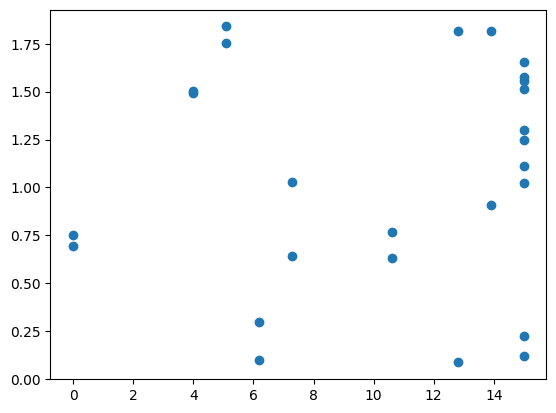

In [12]:
# MAKING SHIFT AND LENGTH ARRAYS FOR PLOTTING
shiftAr = []
PCMlen = []

for col in range(len(MZI_arr)): # 3
    for row in range(len(MZI_arr[0])): # 12
        if MZI_arr[col][row].qual == True:
            PCMlen.append(MZI_arr[col][row].leng)
            print(f"length: {MZI_arr[col][row].leng:.3f}")
            diff = wvlShift(MZI_arr[col][row].exp[0],MZI_arr[col][row].exp[1],row+1,col+1,plot=False)
            shiftAr.append(diff)
            print(f"diff: {diff:.3f}")

plt.scatter(PCMlen,shiftAr)

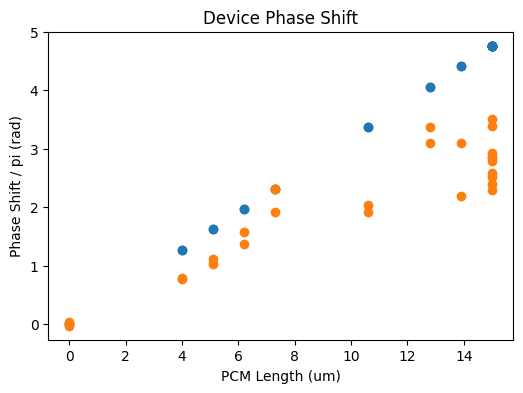

In [24]:
plt.figure(figsize=(6, 4))
plt.title(f"Device Phase Shift")
# plt.xticks(np.arange(wavelength_array[0]-10, wavelength_array[-1]+10, 5.0))
# plt.xticks(rotation=45, ha='right')
plt.xlabel("PCM Length (um)")
plt.ylabel("Phase Shift / pi (rad)")

PCMlen = np.array(PCMlen)
theoShift = 2*PCMlen*(2.181-1.935)/1.55 # (n_cry - n_air) removed pi because axis in terms of *pi n_amo = 2.026
# theoShift = 2*PCMlen*(2.181-2.026)/1.55 # (n_cry - n_amo) removed pi because axis in terms of *pi
plt.scatter(PCMlen,theoShift)
plt.scatter(PCMlen,shiftAr)


1
2
0.0
0.6343047639501878
-0.22597169243550397
-0.6999615542703288
0.545720514196252
-0.011688759268348559
-0.5903083345332549
-0.5891235200559268
-0.5010953884536946
-0.028825813527415256
0.03220399836302601
0.6839248226238999
-0.9683994598582171
0.6788747554661834
-0.40033275031124815
-0.3957931068687601
-0.5008770705766994
-0.48762049409188246
0.028825813527415256
0.0942725919919285
0.16921981460156044
-0.3715539091284006
-0.23802358171393045
-0.1850446106252699
-0.46054173657244135
0.7403145871073518
0.07422943560092232


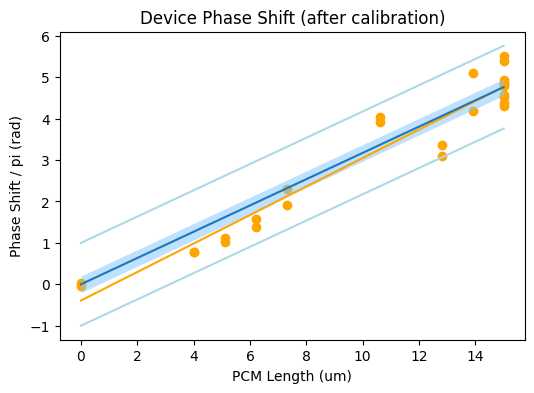

In [ ]:
# ok but actually we need to subtract out the phase shift induced by non-PCM sources like the capping layer and annealing.
# so, I will take the phase shift introduced in the device with PCM length = 0 and subtract that from all other data points.
x = np.linspace(0,15,100)
theoShift1 = 2*x*(2.181-1.935)/1.55 # air 
# theoShift1 = 2*x*(2.181-2.026)/1.55 # amo

print(1)

phaseZero = []

for i in range(len(PCMlen)):
    if PCMlen[i] == 0:
        phaseZero.append(shiftAr[i])

print(2)

phaseZero_avg = sum(phaseZero)/2

print(phaseZero_avg)

shiftAr = shiftAr-phaseZero_avg
for i in range(len(shiftAr)):
    print(shiftAr[i] - theoShift[i])
    while(shiftAr[i] - theoShift[i] < -1):
        shiftAr[i] += 2
    while(shiftAr[i] - theoShift[i] > 1):
        shiftAr[i] -= 2


plt.figure(figsize=(6, 4))
plt.title(f"Device Phase Shift (after calibration)")
plt.xlabel("PCM Length (um)")
plt.ylabel("Phase Shift / pi (rad)")

#here is a change


plt.scatter(PCMlen,shiftAr, color = 'orange')
m,c = np.polyfit(PCMlen,shiftAr,1)
# Generate y-values for the line of best fit
y_fit = m * x + c
plt.plot(x,y_fit, color = 'orange')

plt.plot(x,theoShift1)
plt.plot(x,theoShift1+1, color = "lightblue")
plt.plot(x,theoShift1-1, color = "lightblue")

plt.fill_between(x, theoShift1-.2, theoShift1+.2,
    alpha=.5, edgecolor="#729DC5", facecolor="#7EC5FF",
    linewidth=0)

plt.show()




In [ ]:
# FSR DOT PLOTS I MADE A WHILE AGO - NOT NEEDED ANYMORE

# #Measurement Before PCM Deposition

# fsr = [8.82, 8.98, 8.53, 8.93, 8.97, 8.42, 8.39, 8.82, 8.96, 8.95, 9.00, 8.87, 8.92, 8.96, 8.89, 8.99, 8.98, 9.00, 8.59, 9.02, 8.83, 8.82, 8.97, 8.95, 8.94, 8.94, 8.93, 8.93, 9.01, 8.85, 8.94, 8.89, 8.95, 8.93, 8.97, 8.91]
# fsr_round = np.round(fsr, decimals=1)
# fsr_avg = sum(fsr) / len(fsr)
# fsr_std_dev = np.std(fsr, ddof=0)

# unique_values, counts = np.unique(fsr_round, return_counts=True)
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

# plt.figure(figsize=(6, 4))

# for i, (val, count) in enumerate(zip(unique_values, counts)):
#     plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

# plt.axvline(x=fsr_avg, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg:.2f} nm")
# plt.xticks(np.arange(7.6, 9.3, step=0.2))
# plt.yticks([])
# plt.xlabel("FSR (nm)")
# plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev:.2f})")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(fontsize=11)

# plt.show()




# # Initial Measurement After PCM Deposition

# fsr_idep = [8.19, 8.12, 8.68, 7.90, 8.89, 8.83, 8.51, 8.81, 8.71, 9.01, 8.83, 8.80, 8.67, 8.72, 8.70, 8.42, 8.34, 8.20, 8.88, 8.80, 8.13, 8.90, 8.78, 8.98, 8.72, 8.66, 8.43, 8.64, 8.40, 8.94, 8.49, 8.43, 7.78, 8.27, 8.26, 8.79]
# fsr_round_idep = np.round(fsr_idep, decimals=1)
# fsr_avg_idep = sum(fsr_idep) / len(fsr_idep)
# fsr_std_dev_idep = np.std(fsr_idep, ddof=0)

# unique_values, counts = np.unique(fsr_round_idep, return_counts=True)
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

# plt.figure(figsize=(6, 4))

# for i, (val, count) in enumerate(zip(unique_values, counts)):
#     plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

# plt.axvline(x=fsr_avg_idep, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg_idep:.2f} nm")
# plt.xticks(np.arange(7.6, 9.3, step=0.2))
# plt.yticks([])
# plt.xlabel("FSR (nm)")
# plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev_idep:.2f})")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(fontsize=11)

# plt.show()